In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
import cartopy.feature as cfeature
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
import plot_functions
import importlib 
importlib.reload(plot_functions)
from plot_functions import *
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
# Visualize the result

total cores: 256


In [102]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import socket
hostname = socket.gethostname()
if "nird" in hostname:
    tf.config.threading.set_inter_op_parallelism_threads(8)
    data_loc = "/nird/projects/NS9600K/fslippe/data/"
    folder = "/nird/projects/NS9600K/data/modis/cao/MOD02/2020/ /nird/projects/NS9600K/data/modis/cao/MOD02/2021/ /nird/projects/NS9600K/data/modis/cao/MOD02/2023/"
if "mimi" in hostname:
    data_loc = "/uio/hume/student-u37/fslippe/data/"
    folder = "/scratch/fslippe/modis/MOD02/daytime_1km/ /scratch/fslippe/modis/MOD02/boundary_1km/ /scratch/fslippe/modis/MOD02/night_1km/ /scratch/fslippe/modis/MOD02/may-nov_2021/ /scratch/fslippe/modis/MOD02/cao_test_data/"


bands=[29]
max_vals = np.load("%smodels/max_vals_dnb_l95_z50_ps128_(29)_cao_months_202012-202111.npy" %data_loc)


1 Physical GPUs, 1 Logical GPUs


In [3]:
f = "/uio/hume/student-u37/fslippe/nird_merra/2021"
files = [fi for fi in os.listdir(f) if fi.endswith(".nc")]
files[0]
ds = xr.open_mfdataset("/scratch/fslippe/MERRA/2021/MERRA2_400.inst3_3d_asm_Np.2021*")

#xr.open_dataset("/uio/hume/student-u37/fslippe/nird_merra/2021/MERRA2_400.inst3_3d_asm_Np.20210329.SUB.nc").U.isel(time=0, lev=0).plot()
#plt.figure()
#xr.open_dataset("/uio/hume/student-u37/fslippe/nird_merra/2021/MERRA2_400.inst3_3d_asm_Np.20210329.SUB.nc").V.isel(time=0, lev=0).plot()


In [4]:
import datetime
import numpy as np
import xarray as xr

def find_wind_dir_at_ll_time(lon, lat, p_level, date, time):
    datetime_obj = datetime.datetime.strptime(date + time, "%Y%m%d%H")

    ds = xr.open_dataset("/scratch/fslippe/MERRA/2021/MERRA2_400.inst3_3d_asm_Np.%s.SUB.nc" % date)
    ds_time = ds.sel(time=datetime_obj, lon=lon, lat=lat, lev=p_level, method='nearest')
    wind_dir = np.degrees(np.arctan2(ds_time['V'], ds_time['U']))

    return wind_dir

lon = -10
lat = 70
p_level = 950
date = "20210101"
time = "06"

wind_dir = find_wind_dir_at_ll_time(lon, lat, p_level, date, time)


In [5]:
from autoencoder import SobelFilterLayer, SimpleAutoencoder
print(len(bands))

#encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_band(6,20,29)_encoder")
encoder = load_model("%smodels/encoder_scheduler_250k_dnb_l90_z50_fcao_months_202012_(29)_202111-64" %data_loc)

1


In [104]:
### EXTRACT CAO AND NOn CAO CASES
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
patch_size = 128
start = "20230303"
end = "20230306"
# start = "20201201"
# end = "20210401"
# start = "20210401"
# end = "20210430"

start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)

#x_cao, dates_cao, masks_cao = extract_1km_data("/scratch/fslippe/modis/MOD02/july_2021/", bands=bands, start_date=start_converted, end_date=end_converted)
bands = [29]
# x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min = extract_1km_data("/scratch/fslippe/modis/MOD02/cao_test_data/",
#                                                            bands=bands,
#                                                          start_date=start_converted,
#                                                          end_date=end_converted,
#                                                          return_lon_lat=True)
folder = "/scratch/fslippe/modis/MOD02/2019/ /scratch/fslippe/modis/MOD02/2020/ /scratch/fslippe/modis/MOD02/2021/ /scratch/fslippe/modis/MOD02/2022/ /scratch/fslippe/modis/MOD02/2023/"
x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = extract_1km_data(folder,
                                                         bands=bands,
                                                         start_date=start_converted,
                                                         end_date=end_converted,
                                                         return_lon_lat=True,
                                                         data_loc=data_loc,
                                                         data_type="npy",
                                                         combine_pics=True)

x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = zip(*[(xi, date, mask, lon_lat, mod_min) for xi, date, mask, lon_lat, mod_min in zip(x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao) if (xi.shape[0] > patch_size) and (xi.shape[1] > patch_size)])
x_cao = list(x_cao)
dates_cao = list(dates_cao)
len(x_cao)


total cores: 256
['/scratch/fslippe/modis/MOD02/2019/', '/scratch/fslippe/modis/MOD02/2020/', '/scratch/fslippe/modis/MOD02/2021/', '/scratch/fslippe/modis/MOD02/2022/', '/scratch/fslippe/modis/MOD02/2023/']


IndexError: list index out of range

In [6]:
### EXTRACT CAO AND NOn CAO CASES
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
patch_size = 128
start = "20230303"
end = "20230306"
# start = "20201201"
# end = "20210401"
# start = "20210401"
# end = "20210430"

start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)

#x_cao, dates_cao, masks_cao = extract_1km_data("/scratch/fslippe/modis/MOD02/july_2021/", bands=bands, start_date=start_converted, end_date=end_converted)
bands = [29]
# x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min = extract_1km_data("/scratch/fslippe/modis/MOD02/cao_test_data/",
#                                                            bands=bands,
#                                                          start_date=start_converted,
#                                                          end_date=end_converted,
#                                                          return_lon_lat=True)
folder = "/scratch/fslippe/modis/MOD02/2019/ /scratch/fslippe/modis/MOD02/2020/ /scratch/fslippe/modis/MOD02/2021/ /scratch/fslippe/modis/MOD02/2022/ /scratch/fslippe/modis/MOD02/2023/"
x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = extract_1km_data(folder,
                                                         bands=bands,
                                                         start_date=start_converted,
                                                         end_date=end_converted,
                                                         return_lon_lat=True,
                                                         data_loc=data_loc,
                                                         data_type="npy",
                                                         combine_pics=True)

x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = zip(*[(xi, date, mask, lon_lat, mod_min) for xi, date, mask, lon_lat, mod_min in zip(x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao) if (xi.shape[0] > patch_size) and (xi.shape[1] > patch_size)])
x_cao = list(x_cao)
dates_cao = list(dates_cao)
len(x_cao)


total cores: 256
['/scratch/fslippe/modis/MOD02/2019/', '/scratch/fslippe/modis/MOD02/2020/', '/scratch/fslippe/modis/MOD02/2021/', '/scratch/fslippe/modis/MOD02/2022/', '/scratch/fslippe/modis/MOD02/2023/']


100%|██████████| 4/4 [00:42<00:00, 10.63s/it]


48
48


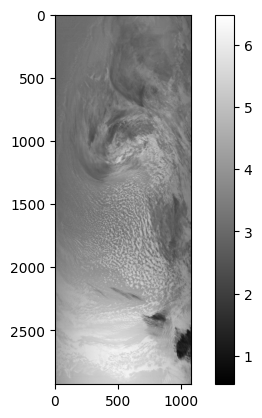

In [101]:
cb = plt.imshow(x_cao[2]*50, cmap="gray")
plt.colorbar(cb)

In [ ]:
for i in range(len(dates_cao)):
    idx = np.where(np.array(mod_min_cao) == mod_min_cao[i])[0][0]
    print(idx)
    print(mod_min_cao)
    extent=[-35, 45, 58, 82]

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(14, 10), dpi=150)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.pcolormesh(lon_lats_cao[idx][0], lon_lats_cao[idx][1], x_cao[idx][:,:,0], cmap='gray', transform=ccrs.PlateCarree())
    #ax.pcolormesh(lon_lats_cao[idx+1][0], lon_lats_cao[idx+1][1], x_cao[idx+1][:,:,0], cmap='gray', transform=ccrs.PlateCarree())
    ax.set_title("%s %s" %(dates[i], mod_min_cao[i]))
    ax.coastlines()
    ax.gridlines()

In [75]:
#### EXTRACTING AND ENCODING PATCHES + SAVING indexes of belonging files
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)
stride = 16
patches_cao, all_lon_patches_cao, all_lat_patches_cao, starts_cao, ends_cao, shapes_cao, n_patches_tot_cao, indices_cao = generate_patches([x[:,:,0] for x in x_cao],
                                                                                                                                       masks_cao,
                                                                                                                                       lon_lats_cao,
                                                                                                                                       max_vals,
                                                                                                                                       autoencoder_predict,
                                                                                                                                       strides=[1, stride, stride,1])
n_patches = len(patches_cao)

In [76]:
autoencoder_predict = SimpleAutoencoder(len(bands), 128, 128)
patches_no_stride, all_lon_patches_no_stride, all_lat_patches_no_stride, starts_no_stride, ends_no_stride, shapes_no_stride, n_patches_tot_no_stride, indices_no_stride = generate_patches([x[:,:,0] for x in x_cao],
                                                                                                                                                                                        masks_cao,
                                                                                                                                                                                        lon_lats_cao,
                                                                                                                                                                                        max_vals,
                                                                                                                                                                                        autoencoder_predict,
                                                                                                                                                                                        strides=[1, patch_size, patch_size,1])

                                                                                                                                                                                        

In [90]:
print(len(patches_no_stride))
n_patches
(patches_cao*max_vals).mean()

2468


0.071184695

In [77]:
n_chunks = 10
chunk_size = n_patches // n_chunks
patch_chunks = [patches_cao[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks)]

encoded_patch_chunks = [encoder.predict(chunk) for chunk in patch_chunks]
encoded_patches_cao = np.concatenate(encoded_patch_chunks)

encoded_patches_flat_cao = encoded_patches_cao.reshape(encoded_patches_cao.shape[0], -1)

gc.collect()


2023-11-17 17:16:47.623577: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


12263

In [78]:
encoded_patches_no_stride = encoder.predict(patches_no_stride)
encoded_patches_flat_no_stride = encoded_patches_no_stride.reshape(encoded_patches_no_stride.shape[0], -1)

gc.collect()

2046

In [79]:
#cluster = joblib.load('/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_scheduler_band(29)_filter_cluster_lab2.pkl')
#cluster_2 = MiniBatchKMeans(15, batch_size=32, random_state=42).fit(encoded_patches_flat_2)
#cluster = MiniBatchKMeans(12, batch_size=1024, init='k-means++', random_state=42).fit(encoded_patches_flat)
#cluster = KMeans(12, init='k-means++', random_state=42).fit(encoded_patches_flat)
cluster = joblib.load("/uio/hume/student-u37/fslippe/data/models/cluster_dnb_l90_z50_ps128_f64_(29)_%s-%s.pkl" %("cao_months_202012", "202111"))

labels = cluster.predict(encoded_patches_flat_cao)
labels_no_stride = cluster.predict(encoded_patches_flat_no_stride)



In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=[10,5])
fig.suptitle("Number of Patches in Each Cluster")
axs[0].set_title("Full dataset")
axs[0].hist(cluster.labels_, bins=np.arange(cluster.n_clusters + 1) - 0.5, edgecolor='k')
axs[0].set_xlabel("Cluster ID")
axs[0].set_ylabel("Count")
axs[0].set_xticks(np.arange(cluster.n_clusters))

axs[1].hist(labels, bins=np.arange(cluster.n_clusters + 1) - 0.5, edgecolor='k')
axs[1].set_title("CAO dataset")
axs[1].set_xlabel("Cluster ID")
axs[1].set_ylabel("Count")
axs[1].set_xticks(np.arange(cluster.n_clusters))
plt.show()


In [ ]:
# from sklearn.manifold import TSNE

# # Reduce dimensionality with t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# reduced_encoded_patches = tsne.fit_transform(encoded_patches_flat_no_stride)
# global_min = np.min([np.min(cm) for cm in cluster.labels_])
# global_max = np.max([np.max(cm) for cm in cluster.labels_])
# norm = Normalize(vmin=global_min, vmax=global_max)  
# # Plot t-SNE results with cluster coloring
# plt.figure(dpi=200)
# plt.scatter(reduced_encoded_patches[::3, 0], reduced_encoded_patches[::3, 1], c=labels_no_stride[::3], s=5, cmap='tab20', norm=norm)
# plt.title("t-SNE visualization with Cluster Coloring")
# plt.colorbar(label="Cluster ID")
# plt.show()



12
(2521, 374, 1)
(1,)


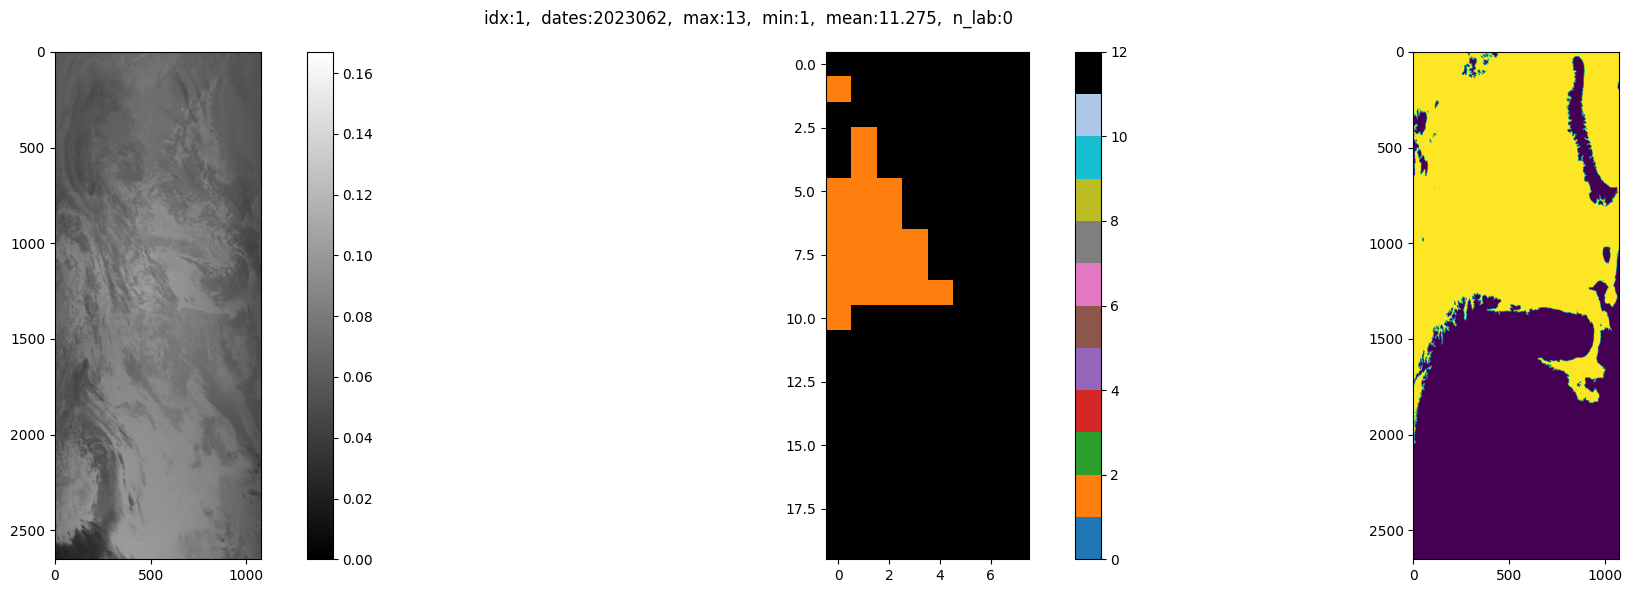

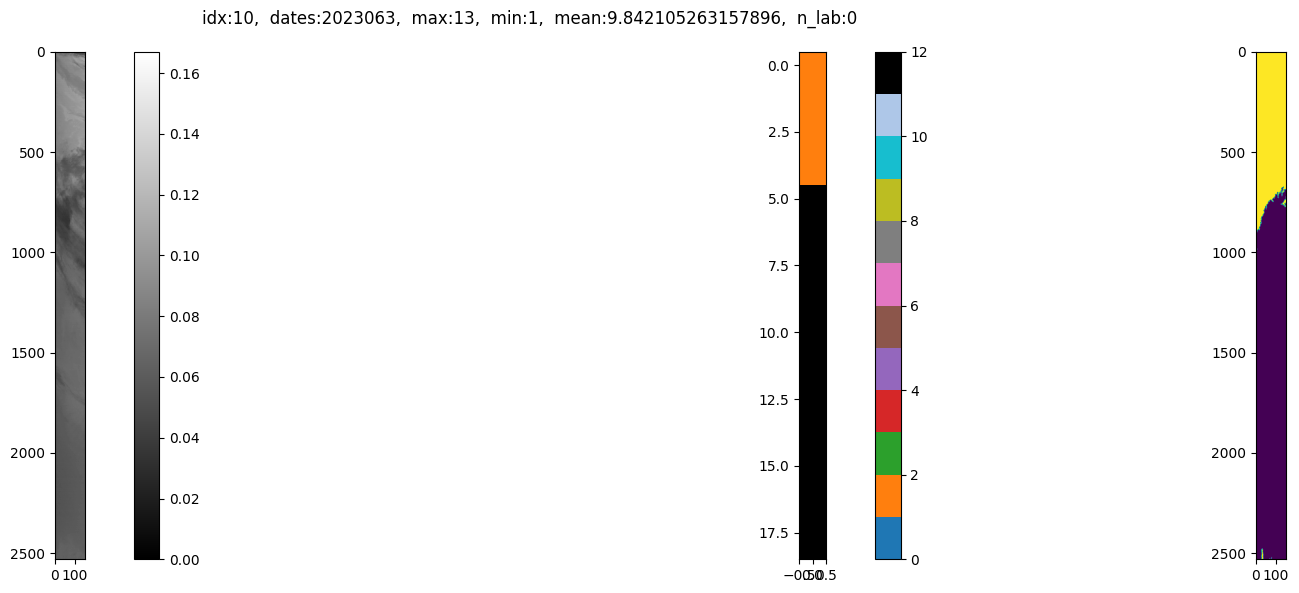

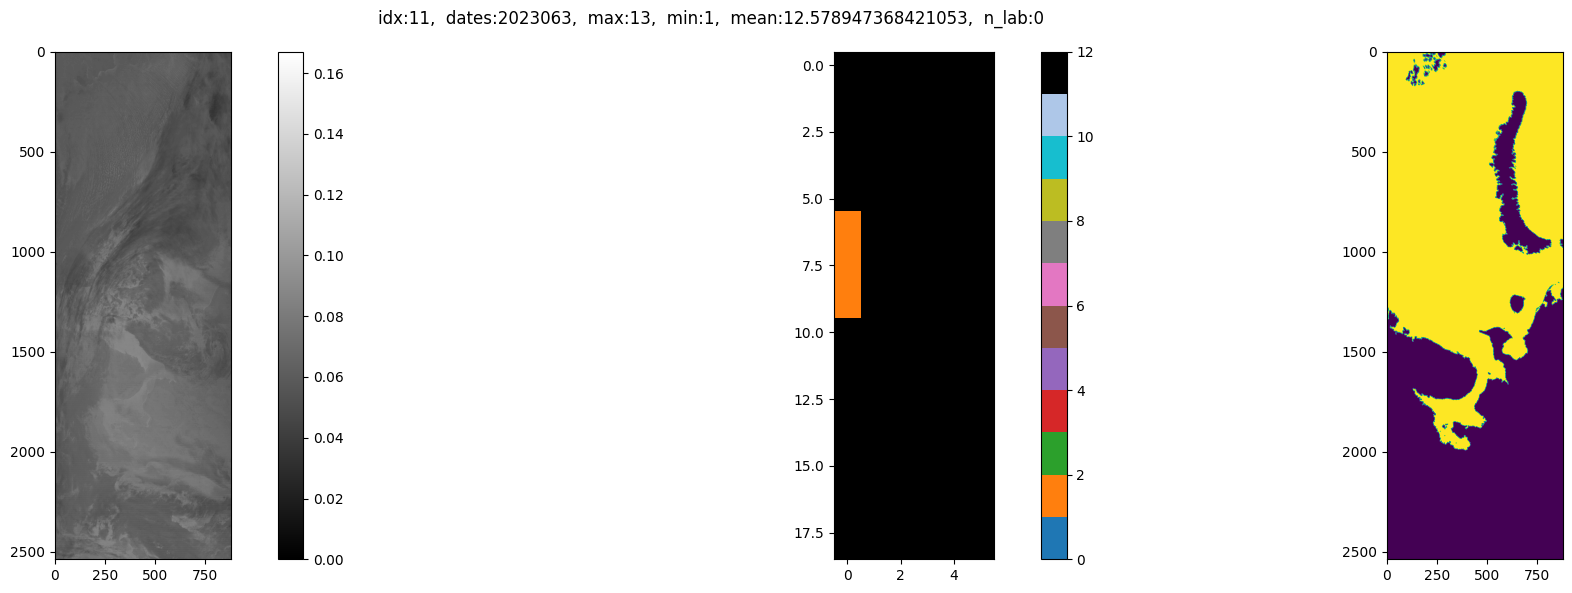

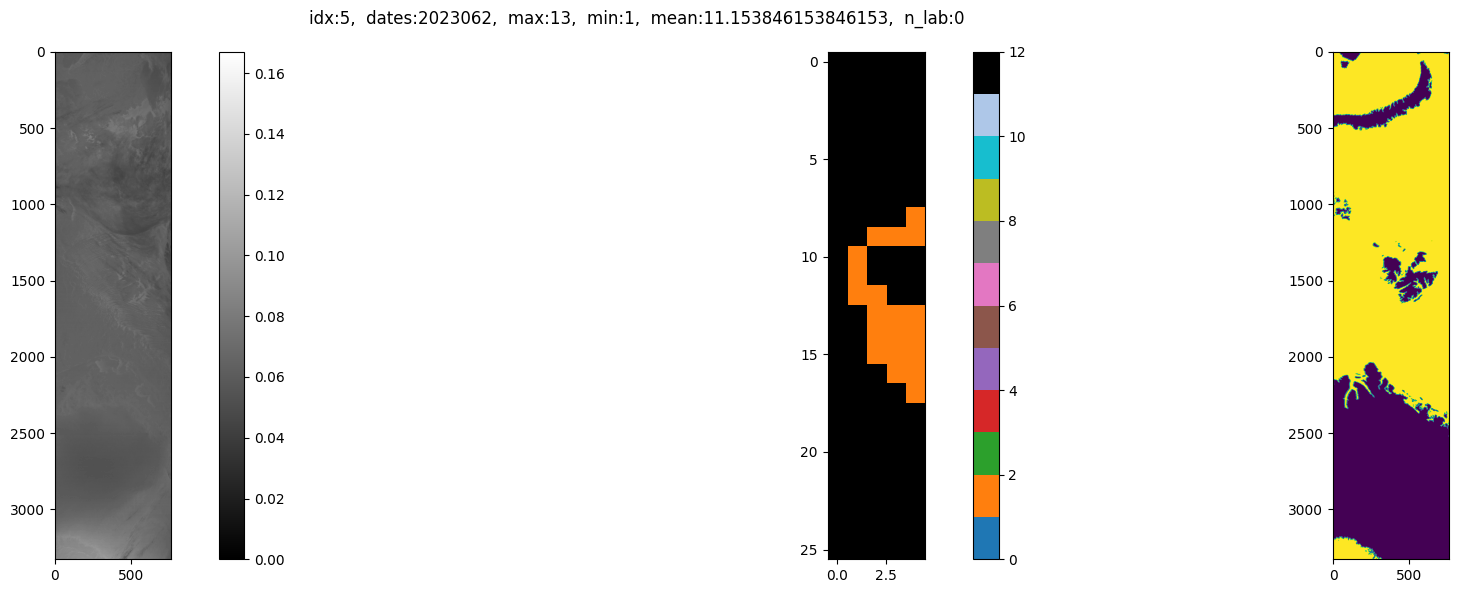

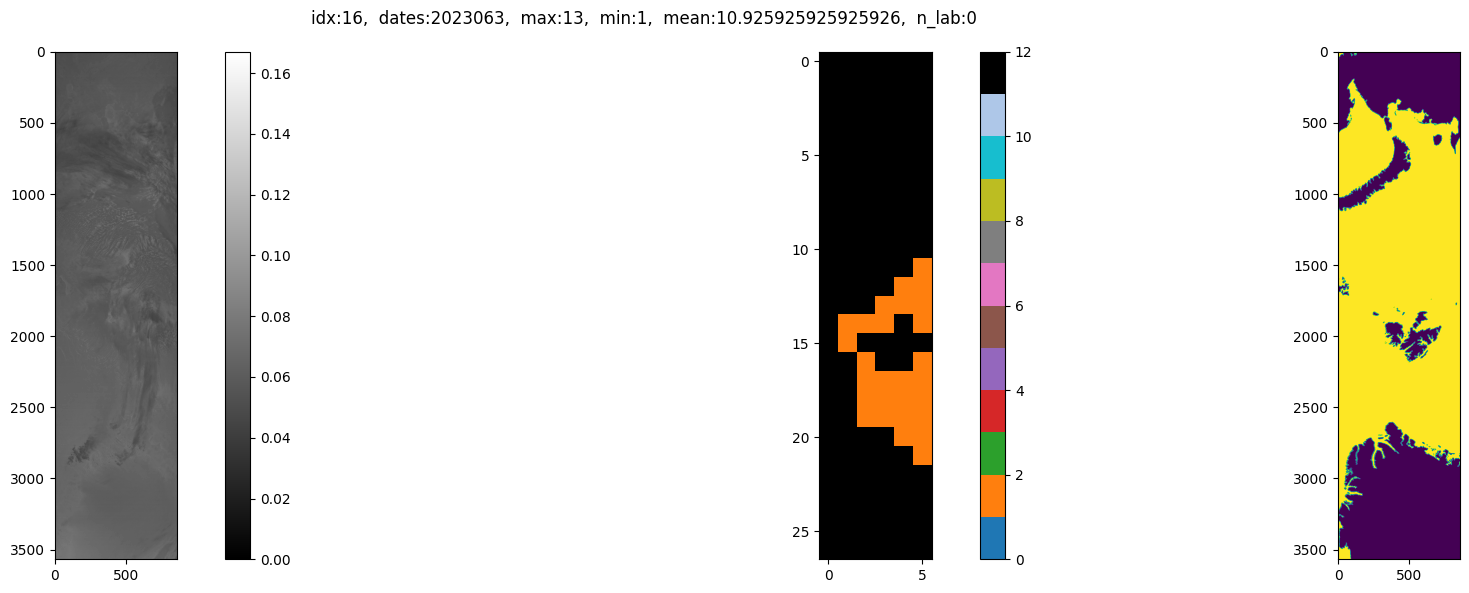

In [88]:
import plot_functions
importlib.reload(plot_functions)
from plot_functions import * 
#index_list = [ 22, 23, 1,2, 3, 6, 8, 9,10,13,15,17]
index_list = [ 1, 2]

index_list = range(len(x_cao))
index_list =[1, 10, 11, 5, 16]

#index_list = [2]

#cluster_predict = cluster.predict(encoded_patches_flat_cao)
#labels = cluster_predict#.labels_
cluster_map_cao = []

global_min = np.min([np.min(cm) for cm in cluster.labels_])
global_max = np.max([np.max(cm) for cm in cluster.labels_])+1
print(global_max)


plot_img_cluster_mask(x_cao,
                      labels_no_stride,
                      masks_cao,
                      starts_no_stride,
                      ends_no_stride,
                      shapes_no_stride,
                      indices_no_stride,
                      dates_cao,
                      n_patches_tot_no_stride,
                      patch_size,
                      global_min,
                      global_max,
                      index_list,
                      chosen_label=3,
                      save=None)
                      


In [ ]:
### P

In [80]:
n_patches_tot_cao[2]

pat_lon = []
pat_lat = []

for i in range(len(all_lon_patches_cao)):
    if all_lon_patches_cao[i].ndim == 2:
        plat = np.mean(np.expand_dims(all_lat_patches_cao[i], axis=0), axis=(1,2))
        plon = np.mean(np.expand_dims(all_lon_patches_cao[i], axis=0), axis=(1,2))

    else:
        plon = np.mean(all_lon_patches_cao[i], axis=(1, 2))
        plat = np.mean(all_lat_patches_cao[i], axis=(1, 2))
    print(plon.shape)
    pat_lon.append(plon)
    pat_lat.append(plat)




pat_lon = np.concatenate(np.array(pat_lon), axis=0)
pat_lat = np.concatenate(np.array(pat_lat), axis=0)
# #cb = plt.imshow(lon_lat_map[1]) 
# #plt.colorbar(cb)
# for i in range(len(x_cao)):
#     print(label[i].shape)
#     print(pat_lon.shape)

(0,)
(1252,)
(7121,)
(7656,)
(2237,)
(1673,)
(2893,)
(4676,)
(6500,)
(3381,)
(76,)
(116,)
(2965,)
(8707,)
(5490,)
(1778,)
(1979,)
(3699,)
(5286,)
(5689,)
(1574,)
(0,)
(877,)
(6012,)
(8133,)
(3037,)
(1706,)
(2619,)
(4446,)
(6274,)
(3979,)
(495,)
(0,)
(2087,)
(8361,)
(6384,)
(1876,)
(1843,)
(3363,)
(4963,)
(6230,)
(2486,)


/tmp/ipykernel_1963346/1606010797.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/tmp/ipykernel_1963346/1606010797.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


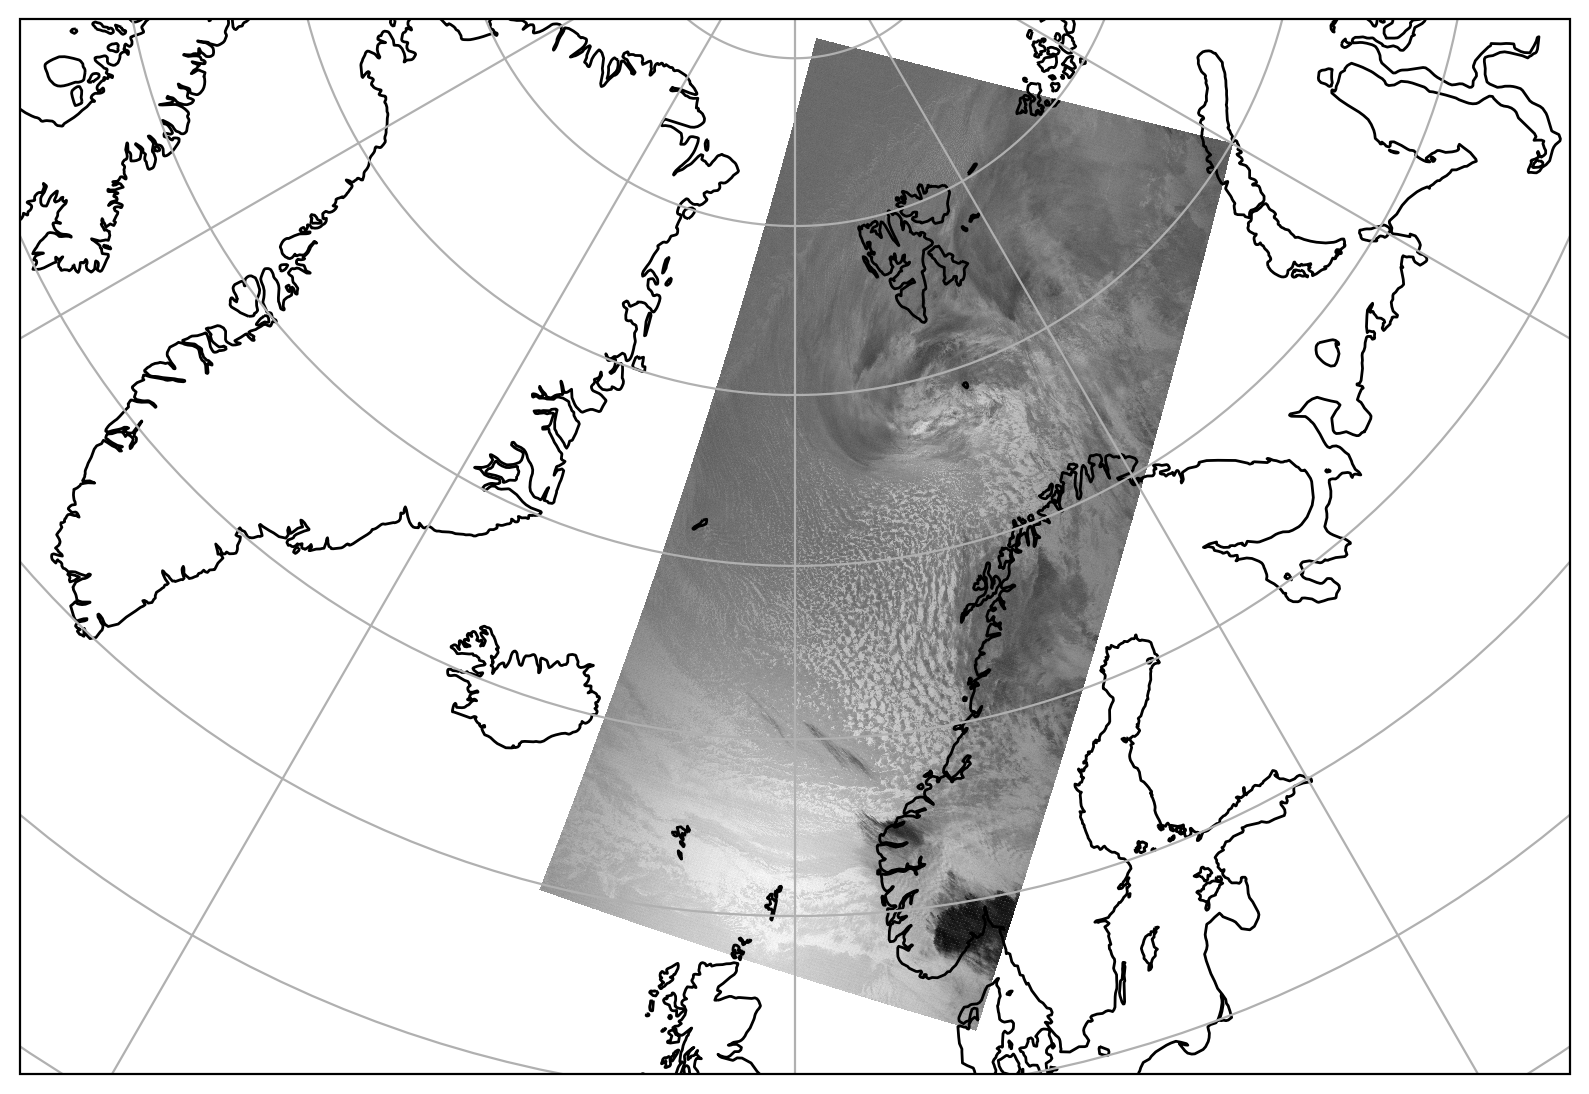

In [86]:
import functions
importlib.reload(functions)
from functions import * 
map = np.empty(len(x_cao), dtype=object)
lon_map = np.empty(len(x_cao), dtype=object)
lat_map = np.empty(len(x_cao), dtype=object)

index_list =[2, 4]#[1, 10, 11, 5, 16]


# stride = 8

for i in index_list:
    map[i] = (generate_map_from_labels(labels, starts_cao[i], ends_cao[i], shapes_cao[i], indices_cao[i], global_max, n_patches_tot_cao[i], patch_size, stride))
    # lon_map.append(generate_map_from_patches(pat, starts_cao[i], ends_cao[i], shapes_cao[i], stride))
    # lat_map.append(generate_map_from_patches(pat, starts_cao[i], ends_cao[i], shapes_cao[i], stride))
    lon_map[i] = (generate_map_from_labels(pat_lon, starts_cao[i], ends_cao[i], shapes_cao[i], indices_cao[i], global_max,  n_patches_tot_cao[i], patch_size, stride))
    lat_map[i] = (generate_map_from_labels(pat_lat, starts_cao[i], ends_cao[i], shapes_cao[i], indices_cao[i], global_max,  n_patches_tot_cao[i], patch_size, stride))





label_1 = 0
label_2 = 3

import plot_functions
importlib.reload(plot_functions)
from plot_functions import * 
for i in index_list:
    lons, lats = compute_boundary_coordinates_between_labels(map[i], lon_map[i], lat_map[i], label_1, label_2)
    plot_map_with_nearest_neighbors(x_cao[i][:,:,0], lons, lats, lon_lats_cao[i][0], lon_lats_cao[i][1])


    

    

In [ ]:
labels_no_stride.max()

In [ ]:
# Define your criteria
idx = 1

lat_condition = (lat_map[idx] > 60) & (lat_map[idx] < 85)
lon_condition = (lon_map[idx] > -40) & (lon_map[idx] < 60)

# Combine the conditions to get the final mask
mask = lat_condition & lon_condition

# Apply the mask to your data
filtered_lon = lon_map[idx][mask]
filtered_lat = lat_map[idx][mask]
filtered_map = map[idx][mask]

if idx == 1:
    extent=[-15, 25, 58, 84]  #[-40, 40, 55, 85]
    title="2023-03-03"
else:
    extent=[-18, 22, 58, 84]
    title="2023-03-06"


cmap_tab10 = plt.cm.tab10
cmap_tab20 = plt.cm.tab20
colors_tab20 = cmap_tab20(np.arange(cmap_tab20.N))[1::2]
colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))
extra_colors = colors_tab20
black = np.array([0, 0, 0, 1])
colors_new = np.vstack((colors_tab10, colors_tab20))[:global_max-1]
colors_new = np.vstack((colors_new, black))

new_cmap = mcolors.ListedColormap(colors_new)
axs[1].set_title("Clustering results")
norm = Normalize(vmin=global_min, vmax=global_max)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(14, 10), dpi=200)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.pcolormesh(lon_lats_cao[idx][0], lon_lats_cao[idx][1], x_cao[idx][:,:,0], cmap='gray', transform=ccrs.PlateCarree())
plt.title("Clustering results\n%s" %title)

sc = ax.scatter(filtered_lon, filtered_lat, c=filtered_map, transform=ccrs.PlateCarree(), cmap=new_cmap, alpha=1, norm=norm)
plt.colorbar(sc, label='Cluster labels', norm=norm)

ax.coastlines()
ax.gridlines()

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(14, 10), dpi=200)
ax.set_extent(extent, crs=ccrs.PlateCarree())
cb = ax.pcolormesh(lon_lats_cao[idx][0], lon_lats_cao[idx][1], x_cao[idx][:,:,0], cmap='gray', transform=ccrs.PlateCarree())
plt.colorbar(cb, label="Wm-2-µm-sr")

#plt.title("Clustering results\n%s" %title)
plt.title("MODIS radiance band 29 (8.4 - 8.7 microns)\n%s" %title)

#sc = ax.scatter(filtered_lon, filtered_lat, c=filtered_map, transform=ccrs.PlateCarree(), cmap=new_cmap, alpha=1, norm=norm)
#plt.colorbar(sc, label='Cluster labels', norm=norm)

ax.coastlines()
ax.gridlines()

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(14, 10), dpi=200)
cb = ax.pcolormesh(lon_lats_cao[idx][0], lon_lats_cao[idx][1], x_cao[idx][:,:,0], cmap='gray', transform=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

plt.colorbar(cb, label="Wm-2-µm-sr")
plt.title("Boundary between Open and closed cells\n%s" %title)

ax.scatter(lons, lats, color='red', s=1, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.show()


In [ ]:
import matplotlib
plt.style.use("bmh")
matplotlib.rcParams.update({'font.size': 12})

pat_lon_no_stride = []
pat_lat_no_stride = []

for i in range(len(all_lon_patches_no_stride)):
    if all_lon_patches_no_stride[i].ndim == 2:
        plat = np.mean(np.expand_dims(all_lat_patches_no_stride[i], axis=0), axis=(1,2))
        plon = np.mean(np.expand_dims(all_lon_patches_no_stride[i], axis=0), axis=(1,2))

    else:
        plon = np.mean(all_lon_patches_no_stride[i], axis=(1, 2))
        plat = np.mean(all_lat_patches_no_stride[i], axis=(1, 2))
    pat_lon_no_stride.append(plon)
    pat_lat_no_stride.append(plat)



pat_lon_no_stride = np.concatenate(np.array(pat_lon_no_stride), axis=0)
pat_lat_no_stride = np.concatenate(np.array(pat_lat_no_stride), axis=0)

def plot_img_and_classes(lon, lat, x, m_lon, m_lat, m, extent=[-15, 25, 58, 84], figsize=(14, 10), cmap= "tab20", title="", alpha=0.05):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=figsize, dpi=200)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    cb = ax.pcolormesh(lon, lat, x, cmap='gray', transform=ccrs.PlateCarree())
    plt.colorbar(cb, label="Wm-2-µm-sr")
    plt.title("MODIS radiance band 29 (8.4 - 8.7 microns)\n%s" %title)

    sc = ax.scatter(m_lon, m_lat, c=m, marker='s', s=1000, transform=ccrs.PlateCarree(), cmap=cmap, alpha=alpha)

    ax.coastlines()
    ax.gridlines()
    plt.tight_layout()

    plt.show()

idx=1

lab_no_stride = generate_map_from_labels(labels_no_stride, starts_no_stride[idx], ends_no_stride[idx], shapes_no_stride[idx], indices_no_stride[idx], global_max, n_patches_tot_no_stride[idx], patch_size, stride=None)
#lab_test_no_stride = generate_map_from_labels(arr_new, starts_no_stride[idx], ends_no_stride[idx], shapes_no_stride[idx], indices_no_stride[idx], global_max, n_patches_tot_no_stride[idx], patch_size, stride=None)
# pat_lon_no_stride_map = generate_map_from_labels(pat_lon_no_stride, starts_no_stride[idx], ends_no_stride[idx], shapes_no_stride[idx], indices_no_stride[idx], global_max, n_patches_tot_no_stride[idx], patch_size, stride=None)
# pat_lat_no_stride_map = generate_map_from_labels(pat_lat_no_stride, starts_no_stride[idx], ends_no_stride[idx], shapes_no_stride[idx], indices_no_stride[idx], global_max, n_patches_tot_no_stride[idx], patch_size, stride=None)

title = "2023-03-03"
fig, axs = plt.subplots(1, 2, figsize=[12, 10])
fig.suptitle(title, fontsize=20)
axs[0].set_title("MODIS radiance band 29")
cb = axs[0].imshow(x_cao[idx], cmap="gray")
plt.colorbar(cb, label="Wm-2-µm-sr")
cmap_tab10 = plt.cm.tab10
cmap_tab20 = plt.cm.tab20
colors_tab20 = cmap_tab20(np.arange(cmap_tab20.N))[1::2]
colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))
extra_colors = colors_tab20
black = np.array([0, 0, 0, 1])
colors_new = np.vstack((colors_tab10, colors_tab20))[:global_max-1]
colors_new = np.vstack((colors_new, black))

new_cmap = mcolors.ListedColormap(colors_new)
axs[1].set_title("Clustering results")
norm = Normalize(vmin=global_min, vmax=global_max)
axs[1].set_title("Clustering results")
norm = Normalize(vmin=global_min, vmax=global_max)
cb = axs[1].imshow(lab_no_stride, cmap=new_cmap, norm=norm)
plt.colorbar(cb, label="clustering label", norm=norm)

#plot_img_and_classes(lon_lats_cao[idx][0], lon_lats_cao[idx][1], x_cao[idx][:,:,0], pat_lon_no_stride_map, pat_lat_no_stride_map, lab_no_stride, extent=[-18, 22, 58, 84], title="2023-06-06", alpha=1)

#plot_img_and_classes(lon_lats_cao[idx][0], lon_lats_cao[idx][1], x_cao[idx][:,:,0], filtered_lon, filtered_lat, filtered_map, title="2023-03-03")


In [ ]:
index_list = range(len(x))

plot_img_cluster_mask(x,
                      labels_no,
                      masks,
                      starts,
                      ends,
                      shapes,
                      indices,
                      dates,
                      n_patches_tot,
                      patch_size,
                      global_min,
                      global_max,
                      index_list,
                      chosen_label=8,
                      save=None)

In [ ]:

#autoencoder = load_model("/uio/hume/student-u37/fslippe/data/models/autoencoder_scheduler_250k_dnb_l90_z50_(29)_cao_months_202012-202111")
#autoencoder = tf.keras.models.load_model("/uio/hume/student-u37/fslippe/data/models/autoencoder_scheduler_250k_dnb_l90_z50_fcao_months_202012_(29)_202111-64", custom_objects={"combined_loss": autoencoder_predict.combined_loss})

In [ ]:
#pred_test = autoencoder.predict(patches_cao)


In [ ]:
# patches_cao.shape
# desired_label = 2
# size_threshold = 15
# import functions
# importlib.reload(functions)
# from functions import *

# patches_w_cao = get_patches_of_img_cao(labels, patches_cao, starts_cao, ends_cao, shapes_cao, indices, global_max, n_patches_tot_cao, desired_label, size_threshold, len(dates_cao),  patch_size)


# train, test = train_test_split(patches_w_cao, test_size=0.15)


In [ ]:


# # Assuming `patches_cao` contains the actual patches
# reconstructed_images = reconstruct_from_patches(patches_cao, shapes_cao, starts_cao, ends_cao, patch_size)
